In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dataframe des perturbations

In [2]:
chaos = pd.read_csv("./chaos_classified_small.csv", index_col = 0)
print("Dimensions du dataframe : ", chaos.shape)

Dimensions du dataframe :  (7315, 15)


Text(0.5, 1.0, 'Effectifs de chaque type de perturbations')

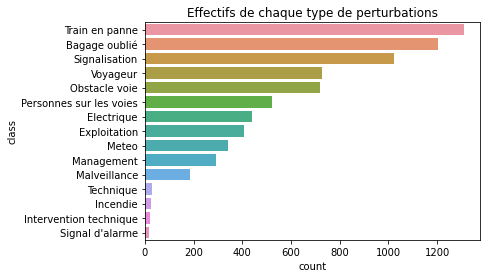

In [3]:
sns.countplot(y="class",data=chaos, order = chaos['class'].value_counts().index)
plt.title("Effectifs de chaque type de perturbations")

In [4]:
rer = {'RER A' : 'line:IDFM:C01742', 
        'RER B': 'line:IDFM:C01743', 
        'RER C' : 'line:IDFM:C01727', 
        'RER D' : 'line:IDFM:C01728',
        'RER E' : 'line:IDFM:C01729'}

In [5]:
chaos.head()

,reference,publication_start_date,publication_end_date,pt_object_type,pt_object_uri,pt_object_name,severity,titre,moteur,notification,application_start_date,application_end_date,created_at,class,line_name
388,46_Dmeyer-20211118065422,2021-11-18 06:50:00+01:00,2021-11-18 11:00:00+01:00,network,network:IDFM:Operator_055,Transports Daniel Meyer,perturbée,Trafic fortement impacté,InfoTrafic : Trafic perturbé ce matinDes reta...,NaN,2021-11-18 06:50:00+01:00,2021-11-18 11:00:00+01:00,2021-11-18 06:57:24+01:00,NaN,NaN
426,50_Hourtoule-20211215145344,2021-12-15 14:50:00+01:00,2021-12-15 15:10:00+01:00,line,line:IDFM:C01869,44,perturbée,PERTURBATION INOPINEE LIGNE 44,Suite à un accident de personne au niveau de l...,NaN,2021-12-15 14:50:00+01:00,2021-12-15 15:10:00+01:00,2021-12-15 14:54:52+01:00,Voyageur,Bus 44
997,keolis4-20210804192850,2021-08-04 19:20:00+02:00,2021-08-04 20:30:00+02:00,line,line:IDFM:C02317,T9,perturbée,Retard T9,Nous vous informons que du retard est à prévoi...,NaN,2021-08-04 19:20:00+02:00,2021-08-04 20:30:00+02:00,2021-08-04 19:30:21+02:00,Obstacle voie,Tramway T9
1003,keolis4-20210809090655,2021-08-09 09:00:00+02:00,2021-08-09 17:00:00+02:00,line,line:IDFM:C02317,T9,perturbée,TRAM T9 : Trafic perturbé,TRAM T9En raison de divers incidents technique...,TRAM T9 : Trafic perturbé dans les 2 sens (div...,2021-08-09 09:00:00+02:00,2021-08-09 17:00:00+02:00,2021-08-09 09:09:49+02:00,NaN,Tramway T9
1027,keolis4-20210901113549,2021-09-01 11:30:00+02:00,2021-09-01 12:26:27+02:00,line,line:IDFM:C02317,T9,perturbée,TRAM T9 : trafic perturbé - avarie matérielle,"En raison d'une avarie matériel, le trafic est...",TRAM T9 : trafic perturbé - avarie matérielle,2021-09-01 11:30:00+02:00,2021-09-01 12:20:00+02:00,2021-09-01 11:37:19+02:00,Train en panne,Tramway T9


In [6]:
def preprocessing(df, rer=None):

    chaos = df[['pt_object_uri',
                'application_start_date',
                'application_end_date', 
                'class',
                'line_name']]
    print("Nbre de perturbations avant le retrait des données manquantes : ", chaos.shape[0])

    #On supprime les données manquantes
    chaos = chaos.dropna()
    print("Nbre de perturbations après le retrait des données manquantes : ", chaos.shape[0])

    if rer!=None:
        #On ne garde que les perturbations concernant les lignes de RER
        rer_list = list(rer.keys())
        chaos = chaos[chaos['line_name'].isin(rer_list)] 
        print("Nbre de perturbations de RER : ", chaos.shape[0])

    #Convertir application_start_date et application_end_date en datetime puis tronquer à l'heure
    for col in ['application_start_date', 'application_end_date']:
        chaos[col] = pd.to_datetime(chaos[col], utc=True)
    chaos['application_start_date'] = chaos['application_start_date'].dt.floor('h')
    chaos['application_end_date'] = chaos['application_end_date'].dt.ceil('h')

    chaos['hour_list'] = ''
    for index, element in chaos.iterrows():
      hour_list = pd.date_range(start=element['application_start_date'], end=element['application_end_date'], freq="H").to_list()
      chaos['hour_list'][index]=hour_list

    chaos = chaos.explode("hour_list")

    #Drop les colonnes qui ne servent plus
    chaos = chaos.drop(['line_name', 'application_start_date', 'application_end_date'], axis = 1)

    chaos = chaos.groupby(["pt_object_uri", "hour_list"]).agg({"class":list}).reset_index()
    chaos["nb_perturbations"] = chaos["class"].apply(len)
    chaos.columns = ["line","datetime","perturbations_type","nb_perturbations"]

    return chaos

In [7]:
chaos_rer = preprocessing(chaos, rer)
chaos_rer.head()

Nbre de perturbations avant le retrait des données manquantes :  7315
Nbre de perturbations après le retrait des données manquantes :  7178
Nbre de perturbations de RER :  4089


C:\Users\Morgane\AppData\Local\Temp\ipykernel_2100\3699485471.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chaos['hour_list'][index]=hour_list


,line,datetime,perturbations_type,nb_perturbations
0,line:IDFM:C01727,2021-08-01 04:00:00+00:00,"[Signalisation, Signalisation, Signalisation]",3
1,line:IDFM:C01727,2021-08-01 05:00:00+00:00,"[Signalisation, Signalisation, Signalisation]",3
2,line:IDFM:C01727,2021-08-01 06:00:00+00:00,"[Signalisation, Signalisation, Signalisation]",3
3,line:IDFM:C01727,2021-08-01 07:00:00+00:00,"[Signalisation, Signalisation, Signalisation]",3
4,line:IDFM:C01727,2021-08-03 05:00:00+00:00,[Train en panne],1


# Dataframe des logs : pour toutes les tranches de 1h pour toutes les lignes

In [8]:
logs = pd.read_csv("./aggregated_final.csv", index_col = 0)
print("Dimensions du dataframe : ", logs.shape)

Dimensions du dataframe :  (6298443, 4)


In [9]:
logs.head()

,Unnamed: 0,entity,datetime,0
0,0,line:IDFM:C00001,2021-12-31 00:00:00,6
1,1,line:IDFM:C00001,2021-12-31 01:00:00,8
2,2,line:IDFM:C00001,2021-12-31 02:00:00,7
3,3,line:IDFM:C00001,2021-12-31 03:00:00,2
4,4,line:IDFM:C00001,2021-12-31 04:00:00,4


In [10]:
def create_logs_df(df_logs, rer=None):

    df = df_logs[['entity', 'datetime', '0']]

    if rer!=None:
        rer_list = rer.values()
        df = df[df['entity'].isin(rer_list)]

    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    df['weekday']=df['datetime'].dt.dayofweek
    df['month']=df['datetime'].dt.month

    df.rename(columns = {'0':'nb_logs'}, inplace = True)
    df=df.reindex(columns=['datetime', 'weekday', 'month', 'entity', 'nb_logs'])

    """
    #One hot encoding sur les lignes de RER
    rer_columns = pd.get_dummies(df['entity'])
    chaos_rer = df.drop('entity',axis = 1)
    # Join the encoded df
    df = df.join(rer_columns)
    """
    
    return df

In [11]:
df = create_logs_df(logs, rer)
df.head()

,datetime,weekday,month,entity,nb_logs
31680,2021-12-31 00:00:00+00:00,4,12,line:IDFM:C01727,648
31681,2021-12-31 01:00:00+00:00,4,12,line:IDFM:C01727,812
31682,2021-12-31 02:00:00+00:00,4,12,line:IDFM:C01727,449
31683,2021-12-31 03:00:00+00:00,4,12,line:IDFM:C01727,296
31684,2021-12-31 04:00:00+00:00,4,12,line:IDFM:C01727,496


# Fusion des 2 Dataframes

In [12]:
def merge_df(chaos, logs):
  merged_df = logs.merge(chaos, how='outer', left_on=["datetime", "entity"], right_on=["datetime","line"])
  merged_df = merged_df.drop(['line'], axis = 1)
  merged_df['nb_perturbations'].fillna(0, inplace=True)
  merged_df['perturbations_type'] = merged_df['perturbations_type'].apply(lambda d: d if isinstance(d, list) else [])
  merged_df = merged_df.dropna()
  cols = ['weekday', 'month', 'nb_logs', 'nb_perturbations']
  merged_df[cols] = merged_df[cols].apply(np.int64)

  #One hot encoding sur les lignes de RER
  rer_columns = pd.get_dummies(merged_df['entity'])
  # Join the encoded df
  merged_df = merged_df.join(rer_columns)
  merged_df = merged_df.drop(['entity'], axis=1)

  return merged_df

In [13]:
merged_df = merge_df(chaos_rer, df)
merged_df.sample(10)

,datetime,weekday,month,nb_logs,perturbations_type,nb_perturbations,line:IDFM:C01727,line:IDFM:C01728,line:IDFM:C01729,line:IDFM:C01742,line:IDFM:C01743
12321,2021-09-23 11:00:00+00:00,3,9,893,[],0,0,0,1,0,0
4330,2021-11-27 00:00:00+00:00,5,11,932,[],0,0,0,0,1,0
11807,2021-09-28 01:00:00+00:00,1,9,20,[],0,0,0,1,0,0
3148,2021-12-06 17:00:00+00:00,0,12,9151,[],0,1,0,0,0,0
14928,2021-09-03 00:00:00+00:00,4,9,45,[],0,0,0,1,0,0
5490,2021-11-18 09:00:00+00:00,3,11,2916,[],0,0,0,0,0,1
16116,2021-08-24 05:00:00+00:00,1,8,1721,[],0,0,0,0,0,1
5367,2021-11-19 11:00:00+00:00,4,11,3246,[Train en panne],1,0,0,0,0,1
3818,2021-12-01 12:00:00+00:00,2,12,1828,[Management],1,0,0,1,0,0
166,2021-12-30 10:00:00+00:00,3,12,3905,[],0,0,1,0,0,0


In [14]:
merged_df.shape

(19120, 11)

In [16]:
merged_df.to_csv('chaos_logs_df.csv')